This notebook contains code for plots used in presentations etc. Since we often have to revise these without wanting to run the entire original analysis, I copy data here from other notebooks. This makes reproducibility harder, maybe I will come up with a better way.

### Model performance comparison

In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from textwrap import wrap

models = ["Last obs.", "Pixel average", "RF", "GAM", "Conv. LSTM"]
labels = np.array(["\n".join(wrap(m, 8)) for m in models])

smooth_r2   = np.array([0.48, 0.62, 0.49, 0.15, 0.41])
smooth_rmse = np.array([0.46, 0.38, 0.54, 1.11, 0.46])

raw_r2   = np.array([0.14, 0.17, 0.07, 0.15, 0.11])
raw_rmse = np.array([1.00, 0.83, 1.08, 1.09, 0.91])

# sort by decreasing rmse
sort_arg = np.argsort(smooth_rmse)[::-1]

labels_sort = labels[sort_arg]
smooth_r2_sort = smooth_r2[sort_arg]
smooth_rmse_sort = smooth_rmse[sort_arg]

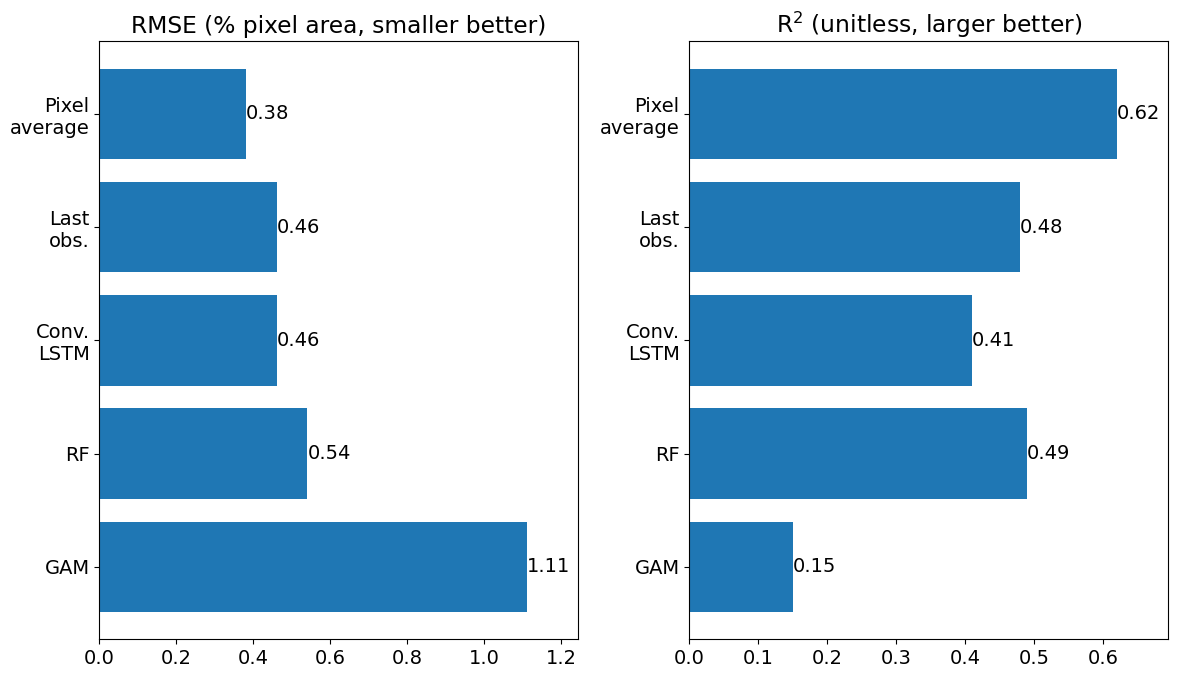

In [2]:
# Only show the results on smoothed models
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
x = np.arange(len(labels))

with plt.rc_context({"font.size": 14}):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
    
    b = ax2.barh(labels_sort, smooth_r2_sort, label="Smoothed")
    ax2.set_yticks(x, labels_sort)
    ax2.set_title("R$^2$ (unitless, larger better)")
    ax2.bar_label(b, fmt="%.2f")
    ax2.margins(x=0.12)
    
    b = ax1.barh(labels_sort, smooth_rmse_sort, label="Smoothed")
    ax1.set_yticks(x, labels_sort)
    ax1.set_title("RMSE (% pixel area, smaller better)")
    ax1.bar_label(b, fmt="%.2f")
    ax1.margins(x=0.12)
    
    plt.tight_layout()

plt.show()

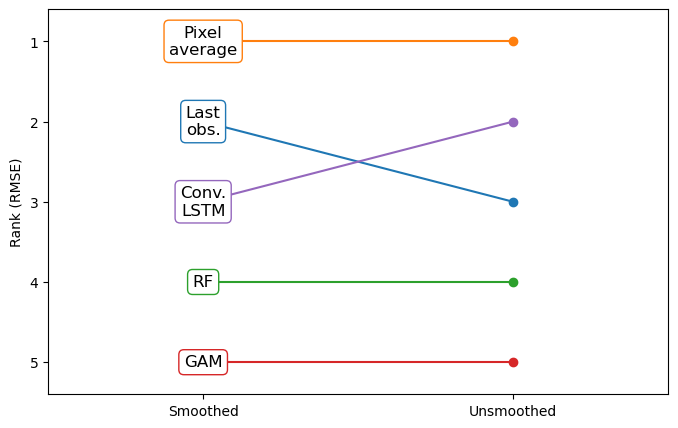

In [3]:
# Show the performance ranking by RMSE of the smoothed vs. unsmoothed models
# Yes, you have to run it twice
# https://yetanothermathprogrammingconsultant.blogspot.com/2022/05/ranking-using-numpyargsort.html

fig, ax = plt.subplots(figsize=(8, 5))
smooth_rank = np.argsort(np.argsort(smooth_rmse))+1
raw_rank    = np.argsort(np.argsort(raw_rmse))+1

for (label, s_rank, r_rank) in zip(labels, smooth_rank, raw_rank):
    p = plt.plot([1, 2], [s_rank, r_rank])
    plt.scatter([1, 2], [s_rank, r_rank])
    plt.text(
        1, s_rank, label, 
        ha="center", va="center", fontsize="large",
        bbox=dict(facecolor='white', edgecolor=p[-1].get_color(), boxstyle='round')
    )

#plt.scatter(np.ones(smooth_rank.shape), smooth_rank)
#plt.scatter(np.ones(raw_rank.shape)+1, raw_rank)
plt.gca().margins(y=0.1, x=0.5)
plt.gca().invert_yaxis()
plt.ylabel("Rank (RMSE)")
plt.xticks([1, 2], ["Smoothed", "Unsmoothed"])
#plt.gca().margins(x=0.1)
#plt.legend()
plt.show()

### Smoothing

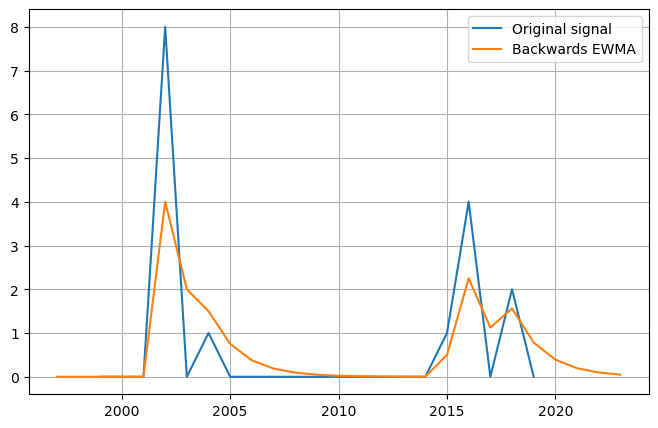

In [4]:
ts_smooth = np.array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.00000000e+00, 2.00000000e+00, 1.50000000e+00,
       7.50000000e-01, 3.75000000e-01, 1.87500000e-01, 9.37500000e-02,
       4.68750000e-02, 2.34375000e-02, 1.17187500e-02, 5.85937500e-03,
       2.92968750e-03, 1.46484375e-03, 5.00732422e-01, 2.25036621e+00,
       1.12518311e+00, 1.56259155e+00, 7.81295776e-01, 3.90647888e-01,
       1.95323944e-01, 9.76619720e-02, 4.88309860e-02])

ts_raw = np.array([np.nan, np.nan,  0.,  0.,  0.,  8.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  4.,  0.,  2.,  0., np.nan, np.nan, np.nan,
       np.nan])

year = np.array([1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008,
       2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023])


fig, ax = plt.subplots(figsize=(8,5))
plt.plot(year, ts_raw, label="Original signal")
plt.plot(year, ts_smooth, label="Backwards EWMA")
plt.grid()
plt.legend()
plt.show()

### Damage area by agent

In [5]:
import geopandas as gpd
import pandas as pd
import os
from matplotlib import pyplot as plt
if 'notebooks' in os.getcwd():
    os.chdir("..")

In [6]:
damage = gpd.read_file("data_working/damage_merged.gdb/", layer="merged")
damage.head()

,SURVEY_YEAR,DCA_CODE,DAMAGE_TYPE_CODE,PERCENT_MID,SEVERITY,geometry
0,2015,11900,2,2.0,2.0,"MULTIPOLYGON (((-12150763.118 4010478.479, -12..."
1,2015,11900,2,2.0,2.0,"MULTIPOLYGON (((-12154550.422 4016632.623, -12..."
2,2015,11900,2,2.0,2.0,"MULTIPOLYGON (((-12162034.763 4026377.771, -12..."
3,2015,11900,2,2.0,2.0,"MULTIPOLYGON (((-12148686.708 4018696.494, -12..."
4,2015,11900,2,2.0,2.0,"MULTIPOLYGON (((-12168432.813 4030879.433, -12..."


In [7]:
damage["area"] = damage.geometry.area
damage["area_sqkm"] = damage["area"] * 1e-6

In [8]:
top_dca = damage.groupby("DCA_CODE").agg({"area_sqkm": "sum"}).reset_index().sort_values(by="area_sqkm", ascending=False)["DCA_CODE"][:4]
print(top_dca)

23    11050
6     11006
2     11002
11    11019
Name: DCA_CODE, dtype: int32


In [9]:
remap_dict = {
    11050: "Fir engraver",
    11006: "Mountain pine beetle",
    11002: "Western pine beetle",
    11019: "Pinyon ips",
}

In [10]:
damage_by_dca_year = damage.groupby(["SURVEY_YEAR", "DCA_CODE"]).agg({"area_sqkm": "sum"}).reset_index()
damage_by_dca_year = damage_by_dca_year[damage_by_dca_year.DCA_CODE.isin(top_dca)]
damage_by_dca_year = damage_by_dca_year.replace({"DCA_CODE": remap_dict})
damage_by_dca_year

,SURVEY_YEAR,DCA_CODE,area_sqkm
1,1997,Western pine beetle,201.065154
3,1997,Mountain pine beetle,1612.062353
7,1997,Pinyon ips,105.864210
13,1997,Fir engraver,425.809159
16,1998,Western pine beetle,203.335149
...,...,...,...
470,2023,Fir engraver,24815.008686
477,2024,Western pine beetle,4017.634794
479,2024,Mountain pine beetle,2870.460411
483,2024,Pinyon ips,34.019156


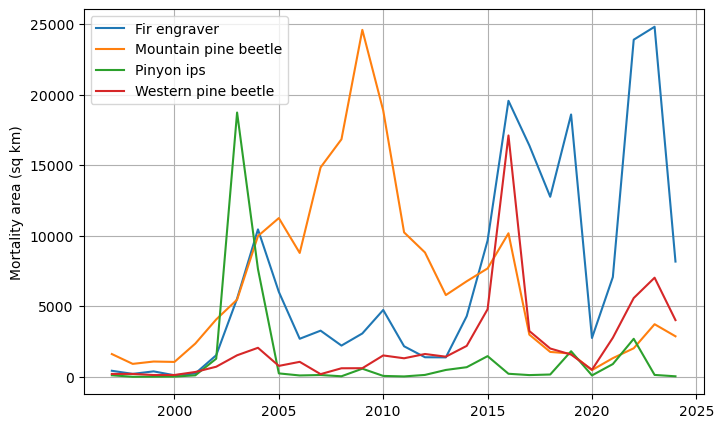

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

for key, data in damage_by_dca_year.groupby("DCA_CODE"):
    data.plot(x="SURVEY_YEAR", y="area_sqkm", label=key, ax=ax)

plt.ylabel("Mortality area (sq km)")
plt.xlabel("")
plt.grid()
plt.show()

### Comparison between ADS and ITM in SOAP/TEAK

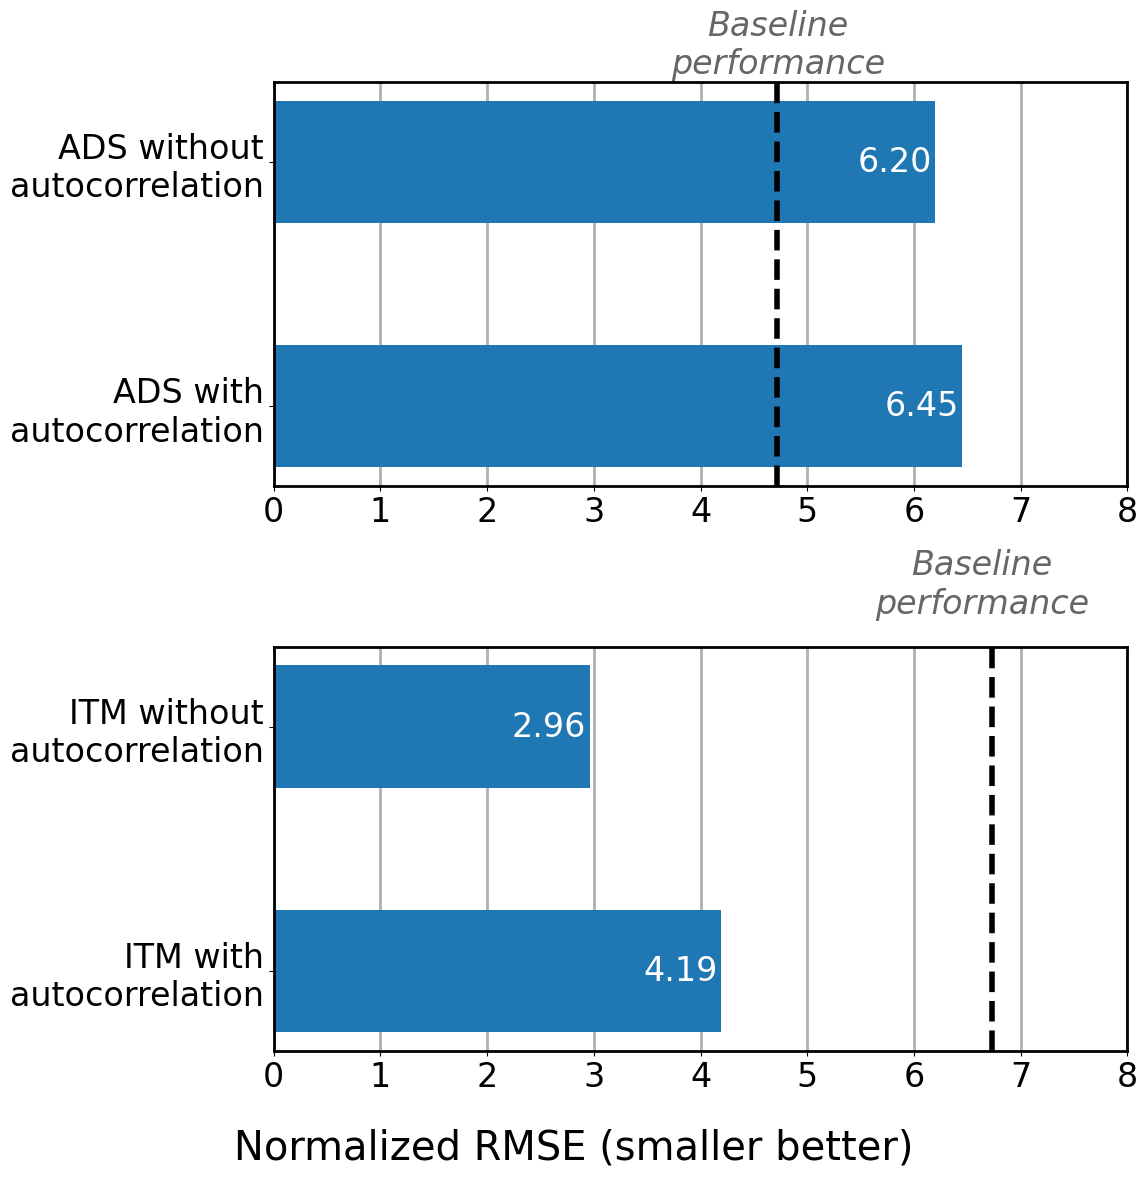

In [117]:
from textwrap import wrap

ads_spatial_nrmse = 6.20
ads_eco_nrmse = 6.45
ads_naive_nrmse = 4.72

itm_spatial_nrmse = 2.96
itm_eco_nrmse = 4.19
itm_naive_nrmse = 6.73

label_width = 20
vline_width = 4.0

with plt.rc_context({"font.size":24, "axes.linewidth": 2.0, "grid.linewidth": 2.0}):
    fig, (top, bottom) = plt.subplots(2, 1, sharex=False, figsize=(12, 17))

    ads_labels = list(map(lambda x: "\n".join(wrap(x, width=label_width)), ["ADS with autocorrelation", "ADS without autocorrelation"]))
    itm_labels = list(map(lambda x: "\n".join(wrap(x, width=label_width)), ["ITM with autocorrelation", "ITM without autocorrelation"]))
    
    # Make top plot
    top.set_axisbelow(True)
    top.grid(axis="x")
    container = top.barh([0, 1], [ads_eco_nrmse, ads_spatial_nrmse], height=0.5)
    top.bar_label(container, fmt="%.2f", padding=-56, color="white")
    top.axvline(ads_naive_nrmse, color="black", linestyle="--", label="Naive baseline", linewidth=vline_width)
    top.set_yticks([0, 1], ads_labels)
    top.set_xlim(None, 8)
    
    # Make bottom plot
    bottom.set_axisbelow(True)
    bottom.grid(axis="x")
    container = bottom.barh([0, 1], [itm_eco_nrmse, itm_spatial_nrmse], height=0.5)
    bottom.bar_label(container, fmt="%.2f", color="white", padding=-56)
    bottom.axvline(itm_naive_nrmse, color="black", linestyle="--", label="Naive baseline", linewidth=vline_width)
    bottom.set_yticks([0, 1], itm_labels)
    bottom.set_xlim(None, 8)

    fig.supxlabel("Normalized RMSE (smaller better)")
    fig.tight_layout(rect=(0, 0, 1, 0.78))
    plt.subplots_adjust(hspace=0.4)
    # annotate naive performance
    plt.gcf().text(0.67, 0.76, "Baseline\nperformance", ha="center", va="bottom", style="italic", color="0.4")
    plt.gcf().text(0.84, 0.388, "Baseline\nperformance", ha="center", va="bottom", style="italic", color="0.4")
    fig.set_size_inches(12, 14.5)
    plt.show()

### Soap Mort and West Mort extents

In [13]:
!pip install -q matplotlib-map-utils contextily

/srv/conda/envs/notebook/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


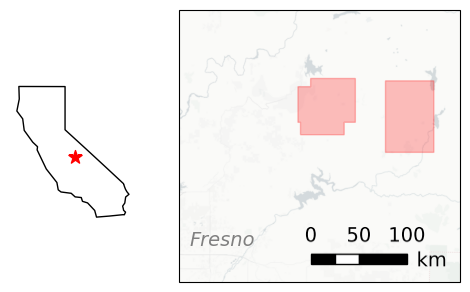

In [14]:
import yaml
import shapely
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import contextily as cx
import matplotlib_map_utils as mpl_map

fn = shpreader.natural_earth(
    resolution='110m', category='cultural', 
    name='admin_1_states_provinces',
)
reader = shpreader.Reader(fn)
cali = next(filter(lambda x: x.attributes["name"] == "California", reader.records()))
cali = gpd.GeoSeries([cali.geometry], crs=4326)

def get_extent_from_yaml(f):
    with open(f) as f:
        config = yaml.safe_load(f)

    bbox = shapely.geometry.box(config["xmin"], config["ymin"], config["xmax"], config["ymax"])
    return gpd.GeoSeries([bbox], crs=config["srs"])

aop_boxes = gpd.read_file("data_in/aop_boundaries/AOP_flightboxesAllSites.shp").to_crs(3857)
soap_teak = aop_boxes[aop_boxes.siteID.isin(["SOAP", "TEAK"])]
soap_teak["geometry"] = soap_teak["geometry"].buffer(100)
soap_teak = soap_teak.dissolve(by="siteID")
centroid = soap_teak.dissolve().centroid

extent_ca = -125.024414, -114.021484, 32.175612, 43.098222
extent_fresno = -119.637744, -118.902283, 36.679433, 37.247821
fresno = -13314904.5252,4404893.9568
projection = ccrs.Mercator.GOOGLE
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(3, 5), width_ratios=[0.3, 0.7], subplot_kw={'projection': projection})

# Left subplot has a star where the sites are
#ax1.coastlines(linewidth=1.0)
cali.to_crs(projection.proj4_init).plot(ax=ax1, edgecolor='black', linewidth=1.0, facecolor="none")
centroid.to_crs(projection.proj4_init).plot(ax=ax1, color="red", marker="*", markersize=100)
ax1.set_extent(extent_ca)
ax1.axis("off")

# Right subplot shows the boundaries of the flight boxes
soap_teak.plot(ax=ax2, alpha=0.25, facecolor="red", edgecolor="red")
ax2.set_extent(extent_fresno)
cx.add_basemap(ax2, source=cx.providers.CartoDB.PositronNoLabels, crs=projection, attribution=False)
mpl_map.scale_bar(
    ax2, location="lower right", 
    bar={
        "projection": projection,
        "unit": "km",
        "max": 100,
        "major_div": 2
    },
    text={"fontsize": 14},
    labels={"sep": 0}
)
ax2.plot(*fresno, markersize=100, transform=projection._as_mpl_transform(ax2))
ax2.annotate('Fresno', xy=fresno, color="0.5", style="italic", fontsize=14, xycoords=projection._as_mpl_transform(ax2))

fig.tight_layout()
fig.set_size_inches(5, 3)
plt.show()

In [15]:
usfs_regions = gpd.read_file("data_in/usfs_region_boundaries/S_USA.AdministrativeRegion.shp")
usfs_regions = usfs_regions[usfs_regions.REGION.isin(["03", "04", "05", "06"])]
usfs_dissolve = gpd.GeoSeries(usfs_regions.geometry.to_crs(3857).buffer(0.02).union_all(), crs=3857).simplify(1000)

# Drop Hawaii
generous_bbox = -15125970.6533,3282511.7427,-9818183.4092,6579699.3948
usfs_dissolve = usfs_dissolve.clip_by_rect(*generous_bbox)

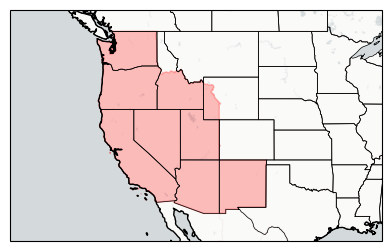

In [16]:
projection = ccrs.Mercator.GOOGLE
map_bbox = (generous_bbox[0], generous_bbox[2], generous_bbox[1], generous_bbox[3]) # >:(
fig, ax = plt.subplots(figsize=(5, 3), subplot_kw={"projection": projection})

ax.coastlines(linewidth=1.0)
ax.add_feature(cfeature.STATES, linewidth=0.5)
usfs_dissolve.plot(ax=ax, facecolor="red", edgecolor="red", alpha=0.25)
ax.set_extent(map_bbox, crs=projection)
cx.add_basemap(ax, source=cx.providers.CartoDB.PositronNoLabels, crs=projection, attribution=False)


plt.show()